# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pickle
from tqdm import tqdm

from sklearn.compose import (
	ColumnTransformer
)
from sklearn.decomposition import (
	PCA
)
from sklearn.ensemble import (
	RandomForestClassifier
)
from sklearn.feature_selection import(
	RFECV, SequentialFeatureSelector
)
from sklearn.linear_model import (
	LinearRegression, LogisticRegression,
)
from sklearn.metrics import (
	confusion_matrix, classification_report, f1_score,
)
from sklearn.model_selection import (
	train_test_split, RandomizedSearchCV, GridSearchCV, 
	cross_val_score,
)
from sklearn.pipeline import (
	Pipeline
)
from sklearn.preprocessing import (
	LabelEncoder, OneHotEncoder, StandardScaler,
	RobustScaler, QuantileTransformer,
)
import statsmodels.api as sm

In [2]:
SEED = 123
TEST_SIZE = 0.25

HEATMAP_COLORS = sns.diverging_palette(h_neg=359, h_pos=250, as_cmap=True)


# Import/Preprocess Data

In [3]:
df = pd.read_pickle(Path('../data/df.pickle'))
print(df.shape)
df.head()

(99, 104)


,a_diameter,age,airway_ratio,airway_volume,anterior_basal_rs8,anterior_ls3,anterior_rs3,anteromedial_basal_ls7_8,apical_ls1,apical_rs1,...,ve_vco2_slope,vo2_hr_peak_percent_,vo2_ml_kg_min_at_at,vo2_work_slope_output,volume_bone,volume_intermuscular_fat,volume_muscle,volume_subcutaneous_fat,volume_visceral_fat,weight_kg
PE1_0,26.7526,49.0,0.011805,0.066788,0.201809,0.206637,0.326371,0.06566,0.0,0.399756,...,NaN,45.0,9.6,NaN,2.03983,0.986196,5.87431,6.59418,0.242408,150.00
PE12_0,21.0758,45.0,0.014465,0.069840,0.395899,0.000000,0.002098,0.00000,0.0,0.041968,...,29.557,75.0,10.7,8.038,1.85461,0.904912,6.00182,4.86750,1.988060,111.50
PE12_1,22.9284,45.0,0.018161,0.047697,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,29.557,75.0,10.7,8.038,2.02425,0.629943,8.01657,6.28189,2.443480,111.50
PE14_0,22.3061,31.0,0.010895,0.054162,0.238598,0.000000,0.000000,0.00000,0.0,0.000000,...,32.776,92.0,10.2,7.718,1.68335,0.347496,5.08316,4.88387,0.470233,85.55
PE15_0,17.0060,18.0,0.013111,0.029738,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,28.446,80.0,17.1,NaN,1.16264,0.168386,3.62723,1.53712,0.017716,55.00


## Identify Target and Independent Variables

In [4]:
# Identify all target columns
# In this case, they will be PE resolution and all 
# clot burden variables.
CAT_TARGETS = [
	'resolved_pe'
]
NUM_TARGETS = [
	'total_clot_burden',
	'centralartery',
	'apical_rs1',
	'posterior_rs2',
	'anterior_rs3',
	'lateral_rs4',
	'medial_rs5',
	'superior_rs6',
	'medial_basal_rs7',
	'anterior_basal_rs8',
	'lateral_basal_rs9',
	'posterior_basal_rs10',
	'apical_ls1',
	'posterior_ls2',
	'anterior_ls3',
	'superior_ls4',
	'inferior_ls5',
	'superior_ls6',
	'anteromedial_basal_ls7_8',
	'lateral_basal_ls9',
	'posterior_basal_ls10',
]
TARGETS = CAT_TARGETS + NUM_TARGETS
# Check columns to drop are named correctly
assert set(TARGETS).issubset(set(df.columns))

# Identify all body composition variables
VFAT_FEAT = ['volume_visceral_fat', 'density_visceral_fat', 'mass_visceral_fat']
SFAT_FEAT = ['volume_subcutaneous_fat', 'density_subcutaneous_fat', 'mass_subcutaneous_fat']
IFAT_FEAT = ['volume_intermuscular_fat', 'density_intermuscular_fat', 'mass_intermuscular_fat']
MUSCLE_FEAT = ['volume_muscle', 'density_muscle', 'mass_muscle']
BONE_FEAT = ['volume_bone', 'density_bone', 'mass_bone']
COMP_FEAT = ['bmi']
BODY_FEAT = VFAT_FEAT + SFAT_FEAT + IFAT_FEAT + MUSCLE_FEAT + BONE_FEAT + COMP_FEAT

# All necessary columns for clot burden predictions
NECESSARY_COLS = TARGETS + BODY_FEAT

# Drop columns
df_nonnull = df.dropna(subset=NECESSARY_COLS)
df_nonnull.shape

(90, 104)

In [5]:
# Separate X
X = df_nonnull.loc[:, df_nonnull.columns.difference(TARGETS)].select_dtypes(['int', 'float'])
# Separate Y
Y = df_nonnull.loc[:, TARGETS]

print(f"X_all.shape: {X.shape}")
print(f"Y_all.shape: {Y.shape}")

X_all.shape: (90, 65)
Y_all.shape: (90, 22)


## Handling Highly Correlated Features

In [6]:
# Create correlation matrix
corr_matrix = X.corr().abs()
# Select upper triangle
upper = corr_matrix.where(
	np.triu(
		np.ones(corr_matrix.shape),
		k=1
	).astype(bool)
)
# Columns to drop
high_corr_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# Show columns to drop (key) and their associate highly correlated columns (item)
{col: list(upper.columns[np.where(upper[col] > 0.95)]) for col in high_corr_drop}

{'peak_cao2': ['peak_arterial_hb'],
 'peak_measured_mpap_mmhg': ['peak_calculated_mpap_mmhg'],
 'peak_vo2_ml_kg_min': ['mets'],
 'study_age_pe': ['age'],
 'volume_bone': ['mass_bone'],
 'volume_intermuscular_fat': ['mass_intermuscular_fat'],
 'volume_muscle': ['mass_muscle'],
 'volume_subcutaneous_fat': ['mass_subcutaneous_fat'],
 'volume_visceral_fat': ['mass_visceral_fat'],
 'weight_kg': ['bsa']}

In [7]:
X = X.drop(columns=high_corr_drop)
X.shape

(90, 55)

In [8]:
BODY_FEAT_UNCORR = [col for col in BODY_FEAT if col in X.columns]
BODY_FEAT_UNCORR

['density_visceral_fat',
 'mass_visceral_fat',
 'density_subcutaneous_fat',
 'mass_subcutaneous_fat',
 'density_intermuscular_fat',
 'mass_intermuscular_fat',
 'density_muscle',
 'mass_muscle',
 'density_bone',
 'mass_bone',
 'bmi']

# OLS Regressions

## Standardize Data

In [9]:
# Standardize data
scaler = StandardScaler()
X_scale = pd.DataFrame(
	scaler.fit_transform(X),
	columns=X.columns,
	index=X.index
)

print(f"X_body_first.shape: {X_scale.shape}")

X_body_first.shape: (90, 55)


## Feature Selection

### Recursive Feature Selection

In [10]:
rfecv_results = dict()

for target in NUM_TARGETS:
	ols = LinearRegression()

	rfecv = RFECV(
		estimator=ols,
		step=1,
		scoring='neg_mean_squared_error',
		cv=10
	)

	rfecv.fit(X_scale[BODY_FEAT_UNCORR], Y[target])
	rfecv_results[target] = rfecv.get_feature_names_out()

rfecv_results

{'total_clot_burden': array(['density_muscle'], dtype=object),
 'centralartery': array(['density_muscle'], dtype=object),
 'apical_rs1': array(['density_intermuscular_fat'], dtype=object),
 'posterior_rs2': array(['density_intermuscular_fat'], dtype=object),
 'anterior_rs3': array(['density_subcutaneous_fat'], dtype=object),
 'lateral_rs4': array(['density_intermuscular_fat'], dtype=object),
 'medial_rs5': array(['density_intermuscular_fat'], dtype=object),
 'superior_rs6': array(['density_intermuscular_fat'], dtype=object),
 'medial_basal_rs7': array(['density_muscle'], dtype=object),
 'anterior_basal_rs8': array(['density_intermuscular_fat'], dtype=object),
 'lateral_basal_rs9': array(['mass_muscle'], dtype=object),
 'posterior_basal_rs10': array(['density_visceral_fat'], dtype=object),
 'apical_ls1': array(['density_muscle'], dtype=object),
 'posterior_ls2': array(['density_visceral_fat'], dtype=object),
 'anterior_ls3': array(['density_muscle'], dtype=object),
 'superior_ls4': arra

### Sequential Feature Selection

In [11]:
sfs_fwd_results = dict()

for target in NUM_TARGETS:
	ols = LinearRegression()

	sfs_fwd = SequentialFeatureSelector(
		estimator=ols,
		n_features_to_select='auto',
		tol=0.01,
		scoring='neg_mean_squared_error',
		direction='forward',
		cv=10
	)

	sfs_fwd.fit(X_scale[BODY_FEAT_UNCORR], Y[target])
	sfs_fwd_results[target] = sfs_fwd.get_feature_names_out()

sfs_fwd_results

{'total_clot_burden': array(['mass_muscle'], dtype=object),
 'centralartery': array(['mass_muscle'], dtype=object),
 'apical_rs1': array(['density_subcutaneous_fat'], dtype=object),
 'posterior_rs2': array(['mass_muscle'], dtype=object),
 'anterior_rs3': array(['density_bone'], dtype=object),
 'lateral_rs4': array(['density_visceral_fat'], dtype=object),
 'medial_rs5': array(['density_muscle'], dtype=object),
 'superior_rs6': array(['density_visceral_fat'], dtype=object),
 'medial_basal_rs7': array(['mass_visceral_fat'], dtype=object),
 'anterior_basal_rs8': array(['mass_muscle'], dtype=object),
 'lateral_basal_rs9': array(['mass_muscle'], dtype=object),
 'posterior_basal_rs10': array(['mass_subcutaneous_fat'], dtype=object),
 'apical_ls1': array(['mass_visceral_fat'], dtype=object),
 'posterior_ls2': array(['mass_muscle'], dtype=object),
 'anterior_ls3': array(['density_muscle'], dtype=object),
 'superior_ls4': array(['density_visceral_fat'], dtype=object),
 'inferior_ls5': array(['de

In [12]:
sfs_bwd_results = dict()

for target in NUM_TARGETS:
	ols = LinearRegression()

	sfs_bwd = SequentialFeatureSelector(
		estimator=ols,
		n_features_to_select='auto',
		tol=0.01,
		scoring='neg_mean_squared_error',
		direction='backward',
		cv=10
	)

	sfs_bwd.fit(X_scale[BODY_FEAT_UNCORR], Y[target])
	sfs_bwd_results[target] = sfs_bwd.get_feature_names_out()

sfs_bwd_results

{'total_clot_burden': array(['mass_subcutaneous_fat'], dtype=object),
 'centralartery': array(['mass_subcutaneous_fat'], dtype=object),
 'apical_rs1': array(['density_visceral_fat', 'mass_visceral_fat',
        'density_subcutaneous_fat', 'mass_subcutaneous_fat',
        'mass_intermuscular_fat', 'density_muscle', 'mass_muscle', 'bmi'],
       dtype=object),
 'posterior_rs2': array(['density_visceral_fat', 'mass_visceral_fat',
        'density_subcutaneous_fat', 'mass_subcutaneous_fat',
        'mass_intermuscular_fat', 'density_muscle', 'mass_muscle', 'bmi'],
       dtype=object),
 'anterior_rs3': array(['density_visceral_fat', 'mass_visceral_fat',
        'density_subcutaneous_fat', 'mass_subcutaneous_fat',
        'density_intermuscular_fat', 'mass_intermuscular_fat',
        'density_muscle', 'mass_muscle', 'density_bone', 'mass_bone'],
       dtype=object),
 'lateral_rs4': array(['density_visceral_fat', 'mass_visceral_fat',
        'density_subcutaneous_fat', 'mass_subcutaneous_fa

## Dependent Variable: Clot Burden

We loop through each of the numerical target variables (the various clot burden measures for different locations, as well as the total clot burden), and perform a simple single-variable OLS regression. Shown below are the statistically significant results at the 95% confidence level.

In [13]:
def ols_regression(Xdata, Ydata, targets, features, controls: list=None):

	ols_results = list()
	
	if controls is not None:
		control_notnull_idx = np.where(Xdata[controls].notnull())[0]
		Xdata = Xdata.iloc[control_notnull_idx]
		Ydata = Ydata.iloc[control_notnull_idx]

	for target in targets:

		y_temp = StandardScaler().fit_transform(Ydata[[target]])
		single_model_results = list()

		for feat in features:
			# Add constant to X data
			if controls is None:
				X_temp = sm.add_constant(Xdata.loc[:, feat])
			else:
				if feat in controls:
					continue
				X_temp = sm.add_constant(Xdata.loc[:, [feat] + controls])
			# Fit regression model
			results_temp = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')
			# Store regression coefs and p-values
			results_df = pd.DataFrame({
				'coef': results_temp.params,
				'pvalue': results_temp.pvalues,
				'nobs': results_temp.nobs,
			}).stack()
			results_df.index = [(item[0].replace(feat, 'variable'), item[1]) for item in results_df.index.tolist()]
			# results_df.name = f"y={target}, X={feat}"
			results_df.name = (target, feat)
			single_model_results.append(results_df)
		# Combine and store results
		all_model_results = pd.concat(single_model_results, axis=1).transpose()
		all_model_results.columns = ['_'.join(item) for item in all_model_results.columns.to_list()]
		all_model_results.index.names = ['y_var', 'x_var']
		ols_results.append(all_model_results)

	ols_cb = pd.concat(ols_results, axis=0)
	print(f"OLS output shape: {ols_cb.shape}")
	return ols_cb

def ols_identify_significant(ols_results, signif_cutoff, out_path):
	signif_cb_bodycomp = (
		ols_results.loc[ols_results.variable_pvalue <= signif_cutoff, :]
		.sort_values(by='variable_pvalue')
	)
	# Save regression output
	signif_cb_bodycomp.to_csv(out_path)
	# Show regression output
	return (
		signif_cb_bodycomp
		.style
			.background_gradient(subset='variable_pvalue')
			.format("{:.3f}")
	)

def ols_heatmap(ols, out_path):
	fig, axs = plt.subplots(figsize=(13, 7))
	sns.heatmap(
		ols.loc[ols['variable_pvalue']<=0.05].variable_coef.unstack(level=1),
		annot=ols.loc[ols['variable_pvalue']<=0.05].variable_pvalue.unstack(level=1), 
		annot_kws={"fontsize":8},
		fmt = '.3f',
		center=0.0,
		cmap=HEATMAP_COLORS,
	)

	for t in axs.texts: 
		t.set_text('p=' + t.get_text())

	axs.set_ylabel('Clot Burden Measure')
	axs.set_xlabel('Body Composition Measure')
	
	plt.savefig(out_path)
	plt.show()

OLS output shape: (231, 6)


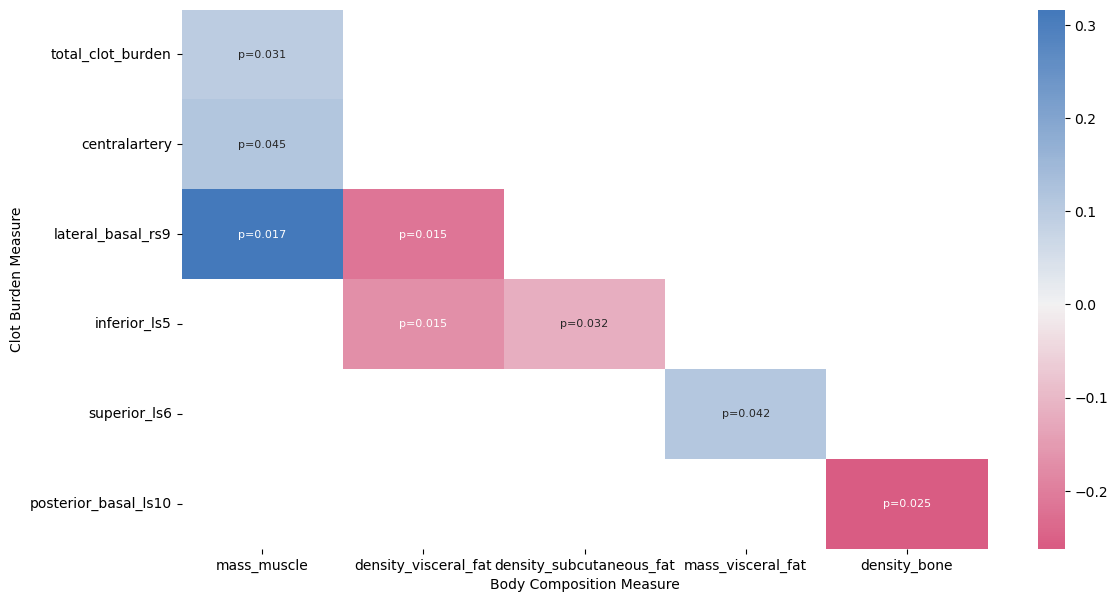

In [14]:
ols = ols_regression(
	Xdata=X_scale,
	Ydata=Y, 
	targets=NUM_TARGETS,
	features=BODY_FEAT_UNCORR
)

ols_heatmap(ols, '../figures/all_ols_cb_heatmap.png')

ols_identify_significant(ols, 0.05, '../output/regressions/all_ols_cb_sig.csv')

OLS output shape: (210, 9)


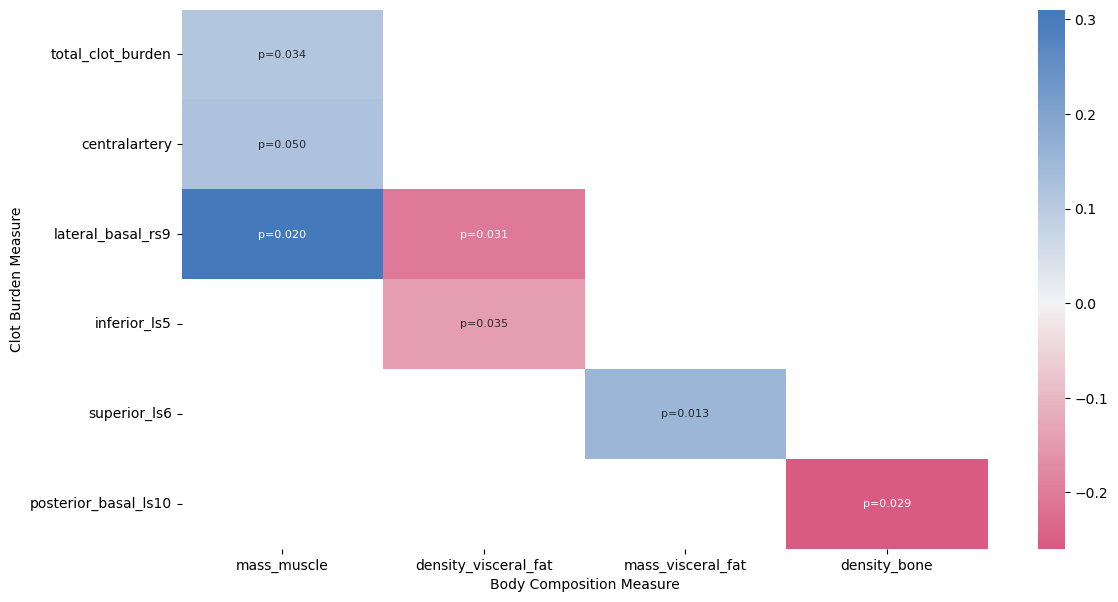

,,const_coef,const_pvalue,const_nobs,variable_coef,variable_pvalue,variable_nobs,bmi_coef,bmi_pvalue,bmi_nobs
y_var,x_var,,,,,,,,,
superior_ls6,mass_visceral_fat,0.000,1.000,90.000,0.153,0.013,90.000,-0.109,0.153,90.000
lateral_basal_rs9,mass_muscle,0.000,1.000,90.000,0.310,0.020,90.000,0.031,0.803,90.000
posterior_basal_ls10,density_bone,-0.000,1.000,90.000,-0.259,0.029,90.000,-0.081,0.556,90.000
lateral_basal_rs9,density_visceral_fat,0.000,1.000,90.000,-0.205,0.031,90.000,0.042,0.747,90.000
total_clot_burden,mass_muscle,0.000,1.000,90.000,0.113,0.034,90.000,-0.063,0.555,90.000
inferior_ls5,density_visceral_fat,0.000,1.000,90.000,-0.143,0.035,90.000,0.103,0.517,90.000
centralartery,mass_muscle,0.000,1.000,90.000,0.123,0.050,90.000,-0.041,0.678,90.000


In [15]:
ols = ols_regression(
	Xdata=X_scale,
	Ydata=Y, 
	targets=NUM_TARGETS,
	features=BODY_FEAT_UNCORR,
	controls=['bmi']
)

ols_heatmap(ols, '../figures/first_ols_cb_bmi_heatmap.png')

ols_identify_significant(ols, 0.05, '../output/regressions/all_ols_cb_sig_bmi.csv')

OLS output shape: (231, 9)


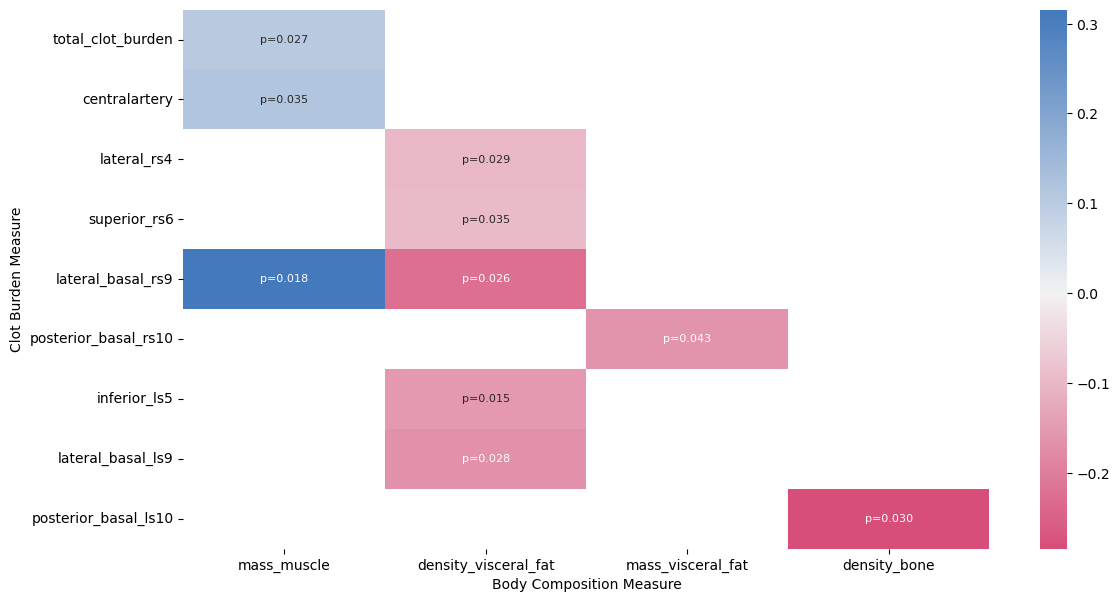

In [16]:
ols = ols_regression(
	Xdata=X_scale,
	Ydata=Y, 
	targets=NUM_TARGETS,
	features=BODY_FEAT_UNCORR,
	controls=['age']
)

ols_heatmap(ols, '../figures/first_ols_cb_age_heatmap.png')

ols_identify_significant(ols, 0.05, '../output/regressions/all_ols_cb_sig_age.csv')

OLS output shape: (210, 12)


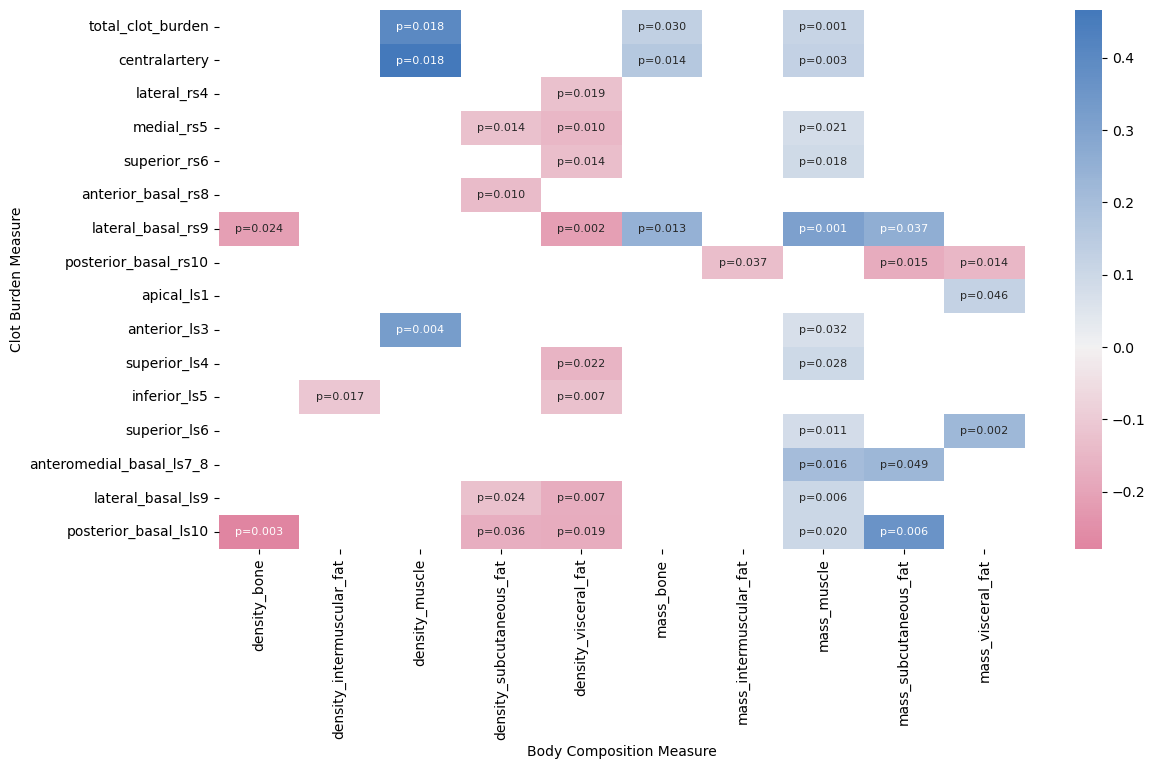

,,const_coef,const_pvalue,const_nobs,variable_coef,variable_pvalue,variable_nobs,age_coef,age_pvalue,age_nobs,bmi_coef,bmi_pvalue,bmi_nobs
y_var,x_var,,,,,,,,,,,,
lateral_basal_rs9,mass_muscle,-0.000,1.000,180.000,0.309,0.001,180.000,0.022,0.728,180.000,0.030,0.734,180.000
total_clot_burden,mass_muscle,-0.000,1.000,180.000,0.114,0.001,180.000,-0.033,0.667,180.000,-0.061,0.419,180.000
lateral_basal_rs9,density_visceral_fat,-0.000,1.000,180.000,-0.212,0.002,180.000,-0.024,0.715,180.000,0.041,0.643,180.000
superior_ls6,mass_visceral_fat,0.000,1.000,180.000,0.224,0.002,180.000,-0.152,0.153,180.000,-0.128,0.025,180.000
centralartery,mass_muscle,0.000,1.000,180.000,0.126,0.003,180.000,-0.062,0.427,180.000,-0.039,0.584,180.000
posterior_basal_ls10,density_bone,-0.000,1.000,180.000,-0.279,0.003,180.000,-0.045,0.579,180.000,-0.078,0.422,180.000
anterior_ls3,density_muscle,-0.000,1.000,180.000,0.323,0.004,180.000,0.114,0.127,180.000,0.062,0.458,180.000
posterior_basal_ls10,mass_subcutaneous_fat,-0.000,1.000,180.000,0.363,0.006,180.000,0.064,0.391,180.000,-0.367,0.000,180.000
lateral_basal_ls9,mass_muscle,0.000,1.000,180.000,0.102,0.006,180.000,-0.010,0.887,180.000,-0.012,0.894,180.000


In [17]:
ols = ols_regression(
	Xdata=X_scale,
	Ydata=Y, 
	targets=NUM_TARGETS,
	features=BODY_FEAT_UNCORR,
	controls=['age', 'bmi']
)

ols_heatmap(ols, '../figures/first_ols_cb_age_bmi_heatmap.png')

ols_identify_significant(ols, 0.05, '../output/regressions/all_ols_cb_sig_age_bmi.csv')